# About

Applying the SVR Ensemble on Retrieval Task.

In [44]:
import numpy as np
import cupy as cp
import pandas as pd
import torch, torch.nn.functional as F
import os
import gc 
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import cudf
import cuml
import numba.cuda

from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from IPython.core.display import display, HTML
from sklearn.manifold import TSNE
from heapq import nlargest
from io import StringIO
from tqdm.auto import tqdm
from transformers import AutoModel,AutoTokenizer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from cuml.svm import SVR as cumlSVR
from cuml.preprocessing import StandardScaler as cumlStandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

/tmp/ipykernel_3117961/1415649699.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [45]:
pd.set_option('display.max_colwidth', None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(device)
print(available_gpus)

cuda
[<torch.cuda.device object at 0x7f720816ceb0>, <torch.cuda.device object at 0x7f720816dc60>]


In [46]:
class Config:
    GERDALIR_PATH = './data/GerDaLIR/'
    EMBEDDINGS_DIRECTORY = './data/embeddings/'
    COMBINED_EMBEDDINGS = './data/embeddings/test/combined_{TYPE}_.npy'
    CHUNK_QUERIES = False

# Read Data

In [47]:
def read_tsv(file_path):
    data = []
    with open(file_path, 'r', encoding='utf8') as file:
        for line in file:
            columns = line.strip().split('\t')
            # Concatenate columns from index 1 onwards (since we have some broken rows)
            concatenated_value = ''.join(columns[1:])
            data.append((columns[0], concatenated_value))

    df = pd.DataFrame(data, columns=['id', 'value'])
    return df

In [48]:
collection = read_tsv(Config.GERDALIR_PATH + 'collection/collection.tsv')
collection.rename(columns={'id': 'd_id', 'value':'passage'}, inplace=True)
collection.reset_index(inplace=True)

rels = read_tsv(Config.GERDALIR_PATH + 'qrels/qrels.test.tsv')
rels.rename(columns={'id': 'q_id', 'value': 'd_id'}, inplace=True)
rels.reset_index(inplace=True)

queries = read_tsv(Config.GERDALIR_PATH + 'queries/queries.test.tsv')
queries.rename(columns={'id': 'q_id', 'value': 'query'}, inplace=True)
queries.reset_index(inplace=True)

In [49]:
display(queries.head(2))
display(len(queries))

display(collection.head(2))
display(len(collection))

display(rels.head(2))
display(len(rels))

,index,q_id,query
0,0,1,Die Antragsgegnerin kann den mit der Ordnungsverfügung vom [DATE] verfügten Widerruf und die Verpflichtung zur Herausgabe der Erlaubnisurkunde gegenüber der Antragstellerin im maßgeblichen Zeitpunkt der Behördenentscheidung
1,1,15,"Hinsichtlich der Ermahnung wendet der Kläger ein, dass die Behörde für den Fall eines Wiederaufnahmeverfahrens verpflichtet sei, zuzuwarten, bis das Verfahren endgültig abgeschlossen ist. Dies gelte umso mehr, da es sich um einen Bußgeldbescheid aus dem Hause des Beklagten handele. Mit diesem Vorbringen setzt sich der Kläger schon nicht hinreichend mit den Ausführungen des Verwaltungsgerichts zur Bindung an rechtskräftige Entscheidungen nach [REF] auseinander, vgl. [REF] . Darüber hinaus steht die Ansicht des Verwaltungsgerichts in Einklang mit der zu dieser Frage ergangenen obergerichtlichen Rechtsprechung und Literatur. Der Betroffene muss den Bußgeldbescheid solange gegen sich gelten lassen, wie die Rechtskraft dieser Entscheidung nicht durch eine Wiedereinsetzung in den vorigen Stand oder eine Wiederaufnahme des gerichtlichen Verfahrens beseitigt wird."


12298

,index,d_id,passage
0,0,1,Tenor Der Antrag der Klägerin auf Zulassung der Berufung gegen das Urteil des Verwaltungsgerichts Gelsenkirchen vom [DATE] wird abgelehnt. Die Klägerin trägt die Kosten des Zulassungsverfahrens. Der Streitwert wird auch für das Zulassungsverfahren auf 0 Euro festgesetzt. Gründe:
1,1,1,"Das Zulassungsvorbringen der Klägerin begründet keine ernstlichen Zweifel an der Richtigkeit des angefochtenen Urteils . Zweifel in diesem Sinn sind anzunehmen, wenn ein einzelner tragender Rechtssatz oder eine einzelne erhebliche Tatsachenfeststellung des Verwaltungsgerichts mit schlüssigen Gegenargumenten in Frage gestellt werden."


3095383

,index,q_id,d_id
0,0,1,72511
1,1,15,12697


14394

# Postprocess

In [50]:
def chunk_string_with_overlap(s, k, overlap):
    if k <= 0:
        raise ValueError("Chunk length must be greater than 0")
    if overlap < 0:
        raise ValueError("Overlap must be non-negative")
    if overlap >= k:
        raise ValueError("Overlap must be less than chunk length")
    
    chunks = []
    for i in range(0, len(s), k - overlap):
        chunk = s[i:i + k]
        chunks.append(chunk)
        if len(chunk) < k:
            break
    
    return chunks

Average length of queries:

In [51]:
print(queries['query'].apply(lambda x: len(x.split())).mean())
print(queries['query'].apply(lambda x: len(x)).mean())

135.19986989754432
1027.8997397950886


In [52]:
if(Config.CHUNK_QUERIES):
    queries['query'] = queries['query'].apply(lambda q: chunk_string_with_overlap(q, 275, 15))
    queries = queries.explode('query').reset_index(drop=True)
    display(queries.head(10))
    print(len(queries))

# Embeddings

The idea was taken from [Chris Deotte](https://www.kaggle.com/code/cdeotte/rapids-svr-starter-cv-0-830-lb-0-804) in the [Automatic Essay Scoring 2.0 competition](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2) on kaggle.

In [53]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [54]:
class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length, text_col):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.max = max_length

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.loc[idx, self.text_col]
        tokens = self.tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=self.max,
                return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

In [55]:
class EmbedderContainer:

    def __init__(self, model_name, max_length, batch_size, device):
        self.device = device
        self.model_name = model_name
        self.__model_path = model_name
        self.__max_length = max_length
        self.__batch_size = batch_size

    def init_model(self):
        self.__model = AutoModel.from_pretrained(self.__model_path, trust_remote_code=True).to(self.device)  #force_download=True
        self.__model.eval()
        self.__tokenizer = AutoTokenizer.from_pretrained(self.__model_path, trust_remote_code=True)  #force_download=True

    def init_embed_dataset(self, df, text_col):
        self.__dataset = EmbedDataset(df, self.__tokenizer, self.__max_length, text_col)
        self.__embed_dataloader = torch.utils.data.DataLoader(self.__dataset,
                                batch_size=self.__batch_size,
                                shuffle=False)
        return self.__embed_dataloader

    def embed(self, input_ids, attention_mask):
        return self.__model(input_ids=input_ids, attention_mask=attention_mask)

    def dispose(self):
        if hasattr(self, '__dataset'):
            del self.__dataset
        if hasattr(self, '__embed_dataloader'):
            del self.__embed_dataloader
        if hasattr(self, '__model'):
            del self.__model
        if hasattr(self, '__tokenizer'):
            del self.__tokenizer
        gc.collect()
        torch.cuda.empty_cache()
    

In [56]:
def get_embeddings(embedding_container, compute_collection=True, compute_queries=False):

    global collection, queries
    embedding_container.init_model()

    # COMPUTE COLLECTION EMBEDDINGS
    all_collection_embeddings = []
    if compute_collection:
        # Create dataset for collection
        embed_dataloader_tr = embedding_container.init_embed_dataset(collection, 'passage')
        for batch in tqdm(embed_dataloader_tr,total=len(embed_dataloader_tr)):
            input_ids = batch["input_ids"].to(embedding_container.device)
            attention_mask = batch["attention_mask"].to(embedding_container.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = embedding_container.embed(input_ids, attention_mask)

            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_collection_embeddings.extend(sentence_embeddings)
    all_collection_embeddings = np.array(all_collection_embeddings)

    # COMPUTE QUERY EMBEDDINGS
    all_query_embeddings = []
    if compute_queries:
        # Create dataset for query
        embed_dataloader_te = embedding_container.init_embed_dataset(queries, 'query')
        for batch in embed_dataloader_te:
            input_ids = batch["input_ids"].to(embedding_container.device)
            attention_mask = batch["attention_mask"].to(embedding_container.device)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = embedding_container.embed(input_ids, attention_mask)
            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            # Normalize the embeddings
            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
            all_query_embeddings.extend(sentence_embeddings)
    all_query_embeddings = np.array(all_query_embeddings)

    # DISPOSE
    if 'model_output' in locals():
        del model_output
    if 'sentence_embeddings' in locals():
        del sentence_embeddings
    if 'input_ids' in locals():
        del input_ids
    if 'attention_mask' in locals():
        del attention_mask
    embedding_container.dispose()

    # RETURN EMBEDDINGS
    return all_collection_embeddings, all_query_embeddings

### Possible Embedding Models

In [57]:
DEVICE = "cuda:1"

container = [
    EmbedderContainer('allenai/longformer-base-4096', 1024, 32, DEVICE),

    # =========== Possible other models, longformer was the best though. ==============
    #EmbedderContainer('microsoft/deberta-base', 1024, 32, DEVICE),
    #EmbedderContainer('microsoft/deberta-large', 1024, 8, DEVICE),
    #EmbedderContainer('microsoft/deberta-v3-large', 1024, 8, DEVICE),
    #EmbedderContainer('LennartKeller/longformer-gottbert-base-8192-aw512', 1024, 32, DEVICE),
    #EmbedderContainer('allenai/longformer-large-4096', 1024, 8, DEVICE),
    #EmbedderContainer('google/bigbird-roberta-base', 1024, 32, DEVICE),
    #EmbedderContainer('google/bigbird-roberta-large', 1024, 8, DEVICE),
    # Sentence Transformers fine-tuned for sentence embeddings:
    # EmbedderContainer('sentence-transformers/all-distilroberta-v1', 512, 32, DEVICE), # https://huggingface.co/sentence-transformers/all-distilroberta-v1
    # EmbedderContainer('sentence-transformers/msmarco-distilbert-base-v4', 512, 32, DEVICE), # https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v4
    #EmbedderContainer('sentence-transformers/all-MiniLM-L6-v2', 384, 64, DEVICE), # https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
]

### Generate Embeddings

In [58]:
all_collection_embeds = []
all_query_embeds = []

calculate = True

In [59]:
if(os.path.exists(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'collection_full'))):
    all_collection_embeds = np.load(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'collection_full'))
    all_query_embeds = np.load(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'query_train'))
    calculate = False

In [60]:
if(calculate):
    for embedding_container in container:
        name = (Config.EMBEDDINGS_DIRECTORY + 
                'collection_' + 
                embedding_container.model_name.replace("/", "_") + 
                ".npy")
        
        if os.path.exists(name):
            print(f"Loading embeddings for {name}")
            _, query_embed = get_embeddings(embedding_container, compute_collection=False, compute_queries=True)
            collection_embed = np.load(name)
        else:
            print(f"Computing embeddings for {name}") 
            collection_embed, query_embed = get_embeddings(embedding_container, compute_collection=True, compute_queries=True)
            np.save(name, collection_embed)
        all_collection_embeds.append(collection_embed)
        all_query_embeds.append(query_embed)

    del collection_embed, query_embed

Loading embeddings for ./data/embeddings/collection_allenai_longformer-base-4096.npy


/home/staff_homes/kboenisc/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [61]:
if(calculate):
    all_collection_embeds = np.concatenate(all_collection_embeds,axis=1)
    all_query_embeds = np.concatenate(all_query_embeds,axis=1)

In [62]:
print(all_collection_embeds.shape)
print(all_query_embeds.shape)

(3095383, 768)
(12298, 768)


In [63]:
gc.collect()

11

In [64]:
if(calculate):
    np.save(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'collection_full'), all_collection_embeds)
    np.save(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'query_train'), all_query_embeds)

# Inference

In [65]:
features = []
labels = []
calculate_feat = True

if(os.path.exists(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'features'))):
    features = np.load(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'features'))
    labels = np.load(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'labels'))
    calculate_feat = False

subsampling_top_k = 50

# query_idx_lookup = {qid: idx for idx, qid in enumerate(queries['q_id'])}
passage_idx_lookup = {pid: idx for idx, pid in enumerate(collection['d_id'])}

In [66]:
def query_fits_passage(q_idx, c_idx):
    '''Does the given collection index fit to a given query index?'''
    q_id = queries.iloc[q_idx]['q_id']
    d_id = collection.iloc[c_idx]['d_id']
    return len(rels[(rels['q_id'] == q_id) & (rels['d_id'] == d_id)].values) > 0

**Convert to cupy arrays for faster GPU cosine sims**

In [67]:
if(calculate_feat):
    all_query_embeds_cp = cp.asarray(all_query_embeds, dtype=cp.float16) 
    all_collection_embeds_cp = cp.asarray(all_collection_embeds, dtype=cp.float16)

In [68]:
# Loop through queries
if(calculate_feat):
    for q_idx, row in tqdm(queries.iterrows(), total=len(queries), desc='Processing Queries'):
        query_id = row['q_id']
        query_embed_cp = all_query_embeds_cp[q_idx]

        # Positive samples
        positive_indices = set()
        rels_for_query = rels[rels['q_id'] == query_id]
        for passage_id in rels_for_query['d_id']:
            if passage_id in passage_idx_lookup:
                passage_idx = passage_idx_lookup[passage_id]
                passage_embed_cp = all_collection_embeds_cp[passage_idx]

                # Convert CuPy arrays back to NumPy
                query_embed_np = cp.asnumpy(query_embed_cp)
                passage_embed_np = cp.asnumpy(passage_embed_cp)

                # Concatenate using NumPy
                feature_np = np.concatenate((query_embed_np, passage_embed_np))
                features.append(feature_np)  # Append NumPy array
                labels.append(1)
                positive_indices.add(passage_idx)
        
        # Compute cosine similarity on GPU
        cos_sim_cp = 1 - cp.matmul(query_embed_cp, all_collection_embeds_cp.T)
        top_k_indices = cp.asnumpy(cp.argpartition(cos_sim_cp, subsampling_top_k + len(positive_indices))[:subsampling_top_k + len(positive_indices)])
        negative_indices = top_k_indices[:subsampling_top_k]

        for passage_idx in negative_indices:
            passage_embed_cp = all_collection_embeds_cp[passage_idx]

            # Convert CuPy arrays back to NumPy
            query_embed_np = cp.asnumpy(query_embed_cp)
            passage_embed_np = cp.asnumpy(passage_embed_cp)

            # Concatenate using NumPy
            feature_np = np.concatenate((query_embed_np, passage_embed_np)).astype(np.float16)
            features.append(feature_np)  # Append NumPy array
            labels.append(0)


Processing Queries:   0%|                                                                     | 0/12298 [00:00<?, ?it/s]

Processing Queries: 100%|█████████████████████████████████████████████████████████| 12298/12298 [03:06<00:00, 65.88it/s]


In [69]:
if(calculate_feat):
    features = np.array(features)
    labels = np.array(labels) 

In [70]:
print(features.dtype)

float16


In [71]:
if(calculate_feat):
    np.save(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'features'), features)
    np.save(Config.COMBINED_EMBEDDINGS.replace('{TYPE}', 'labels'), labels)

In [72]:
print(features.shape)
print(labels.shape)
print(labels[:200])
print('Negative labels: ' + str(len(list(filter(lambda x: x == 0, labels)))))
print('Positive labels: ' + str(len(list(filter(lambda x: x > 0, labels)))))


(629294, 1536)
(629294,)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Negative labels: 614900
Positive labels: 14394


In [73]:
if 'all_collection_embeds' in locals() and 'all_collection_embeds_cp' in locals():
    del all_collection_embeds, all_collection_embeds_cp, all_query_embeds, all_query_embeds_cp
    gc.collect()

In [74]:
X_test = features
y_test = labels

In [75]:
print(len(X_test))
print(len(y_test))

629294
629294


**Load the scaler from the training**

In [76]:
with open('./scalers/cpu_scaler.pkl', 'rb') as file:
    cpu_scaler = pickle.load(file)

In [77]:
X_test_scaled = cpu_scaler.transform(X_test)

## Inference

In [80]:
numba.cuda.select_device(1)

svr_models = []
ensemble_filename = './models/ensemble_svr_models.pkl'

with open(ensemble_filename, 'rb') as file:
    svr_models = pickle.load(file)

**Prediction method for the ensemble:**

In [81]:
def ensemble_predict(svr_models, X, threshold=0.5, proof=1):
    predictions = np.zeros((len(svr_models), len(X)))
    
    for i, svr in enumerate(svr_models):
        predictions[i] = svr.predict(X)
    
    votes = np.sum(predictions > threshold, axis=0)
    final_predictions = (votes >= proof).astype(int)
    return final_predictions

In [82]:
y_pred_binary = ensemble_predict(svr_models, X_test_scaled)

In [83]:
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
class_report = classification_report(y_test, y_pred_binary)

print(f'Test set accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Test set accuracy: 0.9965
Precision: 0.9998
Recall: 0.8488
F1-score: 0.9181
Confusion Matrix:
[[614898      2]
 [  2177  12217]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    614900
           1       1.00      0.85      0.92     14394

    accuracy                           1.00    629294
   macro avg       1.00      0.92      0.96    629294
weighted avg       1.00      1.00      1.00    629294



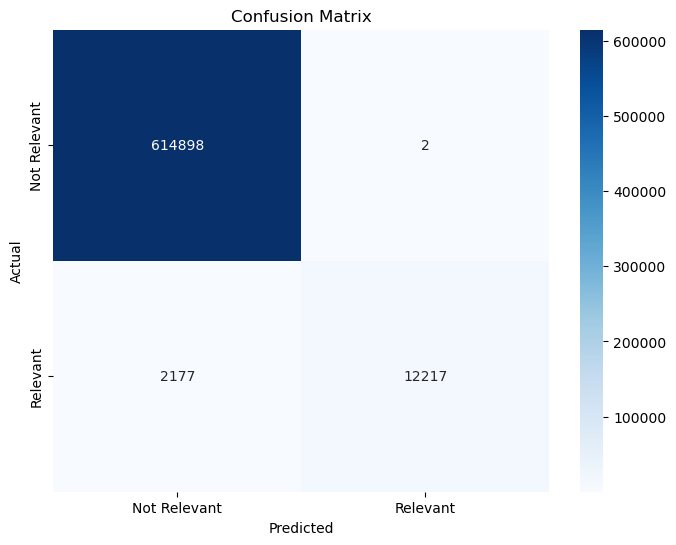

In [84]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Relevant', 'Relevant'], yticklabels=['Not Relevant', 'Relevant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()